# リバースシステム1を試す

In [4]:
from abc import ABC
from backtesting import Strategy
from backtesting.lib import crossover
import algotrade as algo
import pandas as pd
import numpy as np

## データ
Backtesting ingests data as a pandas.DataFrame with columns 'Open', 'High', 'Low', 'Close', and (optionally) 'Volume'. 
Such data is easily obtainable (see e.g. pandas-datareader, Quandl, findatapy, ...). 
Your data frames can have other columns, but these are necessary. 
DataFrame should ideally be indexed with a datetime index (convert it with pd.to_datetime()), 
otherwise a simple range index will do.

In [6]:
# データの読み込み
df = algo.read_fx("../data/AUDJPY_201301_201906.csv", fill_time=True)
df.tail(2)

# データを日足に直す
df = df.resample('1d').ohlc2()
df.tail(2)

#def gen_donchian_singnal(x):
#    if x.Close >= x.phigh:
#        return 1
#    elif x.Close <= x.plow:
#        return -1
#    else:
#        return 0

#df['signal'] = df.apply(lambda x : gen_donchian_singnal(x), axis=1)

,Open,High,Low,Close,Volume
2019-06-20,74.199,74.679,74.131,74.216,0.0
2019-06-21,74.218,74.537,74.188,74.309,0.0


## トレード戦略

In [15]:
def gen_donchian_singnal_series(x, high, low):
    if x >= high:
        return 1
    elif x <= low:
        return -1
    else:
        return 0

# 戦略の定義
class System1(Strategy, ABC):
    
    # Define the two lags as *class variables*
    # for later optimization
    n_past=35
    atr_periods=30
    n_atr=2
    n_day = 40 # n_dayは変えてもあまり結果がかわらない
    
    __n_atr = 3
    __atr = None
    
    def __init__(self, broker, data):

        super().__init__(broker, data)
        # ここは日足で見る
        self.highest_in_range = self.I(algo.highest_in_the_past, self.data.High, self.n_past) # Max
        self.lowest_in_range = self.I(algo.lowest_in_the_past, self.data.Low, self.n_past) # Min
        self.set_atr_periods(self.atr_periods)
        self.set_trailing_sl(self.n_atr)
    
    def set_atr_periods(self, atr_periods: int = 35):
        """
        Set the lookback period for computing ATR. The default value
        of 100 ensures a _stable_ ATR.
        """
        h, l, c_prev = self.data.High, self.data.Low, pd.Series(self.data.Close).shift(1)
        tr = np.max([h - l, (c_prev - h).abs(), (c_prev - l).abs()], axis=0)
        atr = pd.Series(tr).rolling(atr_periods).mean().bfill().values
        self.__atr = atr

    def set_trailing_sl(self, n_atr: float = 2):
        """
        Sets the future trailing stop-loss as some multiple (`n_atr`)
        average true bar ranges away from the current price.
        """
        self.__n_atr = n_atr
        
    def next(self):        
        # ATRに基づいて損切り
        if self.__n_atr and self.position:
            if self.position.is_long:
                self.orders.set_sl(self.data.Close[-1] - self.__atr[-1] * self.__n_atr)
            else:
                self.orders.set_sl(self.data.Close[-1] + self.__atr[-1] * self.__n_atr)

        # 最高値を更新したら買い、最低を更新したら売り
        if crossover(self.data.High, self.highest_in_range):
            self.buy()
        elif crossover(self.lowest_in_range, self.data.Low):
            self.sell()

        # 最高値を更新したあと、戻したら売り、最低を更新したあと、戻したら売り
        if crossover(self.highest_in_range, self.data.High):
            self.sell()
        elif crossover(self.data.Low, self.lowest_in_range):
            self.buy()

        # 経過日数に基づいてポジションのクローズ
        if self.position and (self.position.pl <= 0):
            if (self.data.index[0] - self.position.open_time).days > self.n_day:
                self.position.close()

            
    
        
    

## バックテストを実行

In [16]:
from backtesting import Backtest

bt = Backtest(df, System1, cash=7000, commission=0)
bt.run()

/Users/TakahiroKONNO/PycharmProjects/algotrade/venv/lib/python3.7/site-packages/backtesting/backtesting.py:868: FutureWarning: Timedelta.resolution is deprecated, in a future version will behave like the standard library datetime.timedelta.resolution attribute.  Use Timedelta.resolution_string instead.
  return value.ceil(_period.resolution) if isinstance(value, pd.Timedelta) else value


Start                     2013-01-01 00:00:00
End                       2019-06-21 00:00:00
Duration                   2362 days 00:00:00
Exposure [%]                          56.5199
Equity Final [$]                      7657.82
Equity Peak [$]                       9252.47
Return [%]                            9.39745
Buy & Hold Return [%]                 18.5021
Max. Drawdown [%]                    -30.1811
Avg. Drawdown [%]                    -2.05332
Max. Drawdown Duration      243 days 00:00:00
Avg. Drawdown Duration       46 days 00:00:00
# Trades                                  373
Win Rate [%]                          39.6783
Best Trade [%]                        4.53962
Worst Trade [%]                      -5.38856
Avg. Trade [%]                      0.0253206
Max. Trade Duration          35 days 00:00:00
Avg. Trade Duration           4 days 00:00:00
Expectancy [%]                       0.848084
SQN                                  0.377256
Sharpe Ratio                      

In [398]:
# バックテストの結果を可視化
bt.plot(plot_width= 600)

## 最適化

In [399]:
%%time

stats, heatmap = bt.optimize(
    n_past=range(20, 60, 5),
    atr_periods=range(5, 40, 5),
    n_atr=range(1, 3, 1),
    n_day=range(40, 80, 20),
    maximize='Equity Final [$]',
    return_heatmap=True)
stats

CPU times: user 1.32 s, sys: 519 ms, total: 1.84 s
Wall time: 50.5 s


Start                                                   2014-01-01 00:00:00
End                                                     2019-06-21 00:00:00
Duration                                                 1997 days 00:00:00
Exposure [%]                                                        79.4191
Equity Final [$]                                                    8988.11
Equity Peak [$]                                                      9400.9
Return [%]                                                          28.4015
Buy & Hold Return [%]                                               20.7776
Max. Drawdown [%]                                                  -23.8203
Avg. Drawdown [%]                                                  -2.16737
Max. Drawdown Duration                                   1074 days 00:00:00
Avg. Drawdown Duration                                     52 days 00:00:00
# Trades                                                                242
Win Rate [%]

In [400]:
# stats._strategy

<Strategy System1(n_past=40,atr_periods=5,n_atr=2,n_day=40)>

In [405]:
# バックテストの結果を可視化
bt.plot(plot_width= 600)

In [386]:
heatmap

n_past  periods  n_atr  n_day
20      5        1      40       8176.513366
                        60       8176.513366
                 2      40       8303.479861
                        60       8303.479861
        10       1      40       7705.697121
                                    ...     
55      30       2      60       7837.150517
        35       1      40       7949.407851
                        60       7949.407851
                 2      40       7822.979144
                        60       7822.979144
Length: 224, dtype: float64

In [387]:
heatmap.sort_values().iloc[-3:]

n_past  periods  n_atr  n_day
35      35       2      40       9299.850977
        30       2      40       9308.155416
                        60       9308.155416
dtype: float64

In [338]:
hm = heatmap.groupby(['n_past', 'periods', 'n_atr',]).mean().unstack()
hm

n_atr                     1            2            3
n_past periods                                       
5      5        7140.671351  7152.794308  7109.336526
       10       7227.288283  7221.944332  7304.166212
       15       7169.312235  7175.101914  7607.951521
       20       7207.819699  7269.374930  7494.794572
       25       7188.045713  7299.753987  7476.821516
...                     ...          ...          ...
55     25       6900.488737  6779.201622  6910.482687
       30       6926.597460  6814.326725  6886.680277
       35       6919.590979  6800.110304  6944.405955
       40       6951.791021  6783.747882  6832.419840
       45       6974.533107  6879.383026  6822.803485

[99 rows x 3 columns]

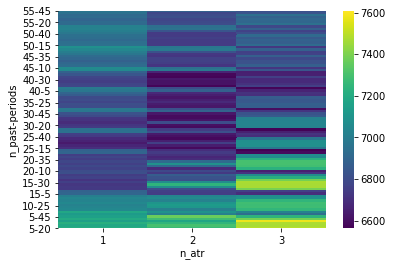

In [388]:
%matplotlib inline

import seaborn as sns


sns.heatmap(hm[::-1], cmap='viridis')

実際には、2σが口座の2パーセントの金額になるように取引数量を決める